## 1. Problem Formulation

In this section, we will do some predictive analysis to bring competitive values beside descriptive analysis as we did in section 1 and 2. Based on my experience, I think that four usecases could be solved by our data, they are:

***A. Time to delivery estimation***

***B. Freight value prediction***

***C. Rating score prediction***

***D. Life time value prediction***

Although usecase D is very common in Ecommerce and Marketing domains, but Olist's customers are mostly new, so new customers will have LTV equal the average current customers and applying Machine Learning in this context is not necessary. Moreover, as we saw in section 1 (EDA), our ratings mostly fall in the quite small range of 3.95 to 4.2. This is quite a high number. In addition, ratings do not directly bring revenue. Therefore, predicting and improving Olist's rating is not really necessary. We then will focus on the first two usecases.

Note that in practice, estimated delivery time and freight value are important factors affecting customer's decision. Therefore, they should be displayed as early as possible when customers consider whether to place an order or not.

To avoid data leakage problem, we only use **features before labelling time** only, i.e. only use features created at the time of order. Because of their similarity and frequent appearance together, we can use the same set of features for these two problems.

## 2. Data processing

In [1]:
import pandas as pd

df = pd.read_csv('../raw/olist.csv')
df_geo = pd.read_csv('../raw/olist_geolocation_dataset.csv')
df_geo = df_geo[df_geo.columns[:-2]].groupby('geolocation_zip_code_prefix').mean().reset_index()

In [2]:
# Remove bad records with null deliver time
df = df[df.order_delivered_customer_date.notnull()]

#### 2.1. Label processing

I will use **time_to_delivery** and **freight_value** as label for usecase A & B, respectively. Usecase B will be solved as a regression problem while usecase A will be considered as a classification one. Because classification problems are easier to achieve a good model and better than regression problems in term of explainability.

<Axes: xlabel='time_to_delivery', ylabel='Count'>

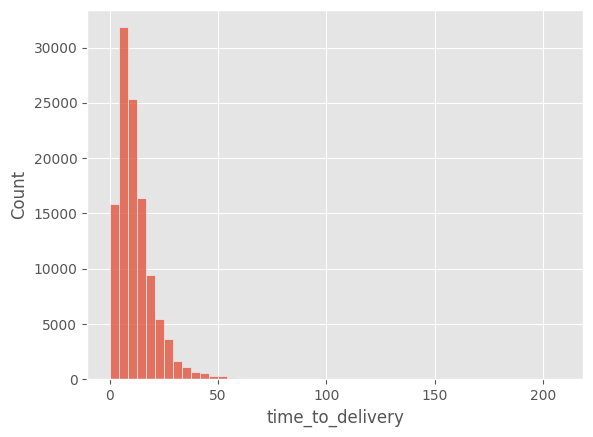

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

sns.histplot(df['time_to_delivery'], bins=50)

As we could see in the chart above, most of orders are shipped within 1 month (~96%), so that we could combine long deliveries into a single group. We then got a multiclass classification problem with 30 different classes from 1 to 29 and 30+. Moreover, output of this model will be compared with current delivery estimation (`delivery_against_estimated`).

In [4]:
df['time_to_delivery_update'] = df['time_to_delivery'].apply(lambda x: '30+' if x >=30 else x).astype(str)

#### 2.2. Potential features

We will create some essential features related to the **distance between customers and sellers**. Currently, we can only calculate the distance as the crow flies. We can calculate the distance in more detail if we know the location of the delivery locations. I will assume we have transit points at the central area of each states, and goods will be shipped to the nearest hub close to seller, then transported directly to the nearest hub close to customer, and finally received by customer. For simplicity, we will only calculate the distance as the crow flies, but ignore other topographical issues such as detours and complex terrain.

In [5]:
df = (df
      .merge(
          df_geo, 
          left_on='customer_zip_code_prefix', 
          right_on='geolocation_zip_code_prefix',
          how='left'
      )
      .rename(columns={'geolocation_lat': 'customer_lat', 'geolocation_lng': 'customer_lng'})
      .merge(
          df_geo, 
          left_on='seller_zip_code_prefix', 
          right_on='geolocation_zip_code_prefix',
          how='left'
      )
      .rename(columns={'geolocation_lat': 'seller_lat', 'geolocation_lng': 'seller_lng'})
    )

# Transit points: based on customer location
df_transit = (df.groupby('customer_state')
              [['customer_lat', 'customer_lng']].mean()
              .reset_index()
              .rename(columns={'customer_lat': 'transit_lat', 'customer_lng': 'transit_lng'})
             )

df = (df
      .merge(df_transit, on='customer_state', how='left')
      .rename(columns={'transit_lat': 'transit_customer_lat', 'transit_lng': 'transit_customer_lng'})
      .merge(df_transit.rename(columns={'customer_state': 'seller_state'}), on='seller_state', how='left')
      .rename(columns={'transit_lat': 'transit_seller_lat', 'transit_lng': 'transit_seller_lng'})
     )

# Replace null value in customer & seller lat, lng with transit 
for col in ['customer_lat', 'customer_lng', 'seller_lat', 'seller_lng']:
    df.loc[df[col].isnull(), col] = df.loc[df[col].isnull(), f'transit_{col}']

In [6]:
from geopy import distance

# Straight line distance between seller and customer
df['cust_sell_straight_line'] = df.apply(lambda x: round(distance.distance((x['customer_lat'], x['customer_lng']), 
                                                                           (x['seller_lat'], x['seller_lng'])).km, 2), axis=1)

# Distance when passing through transit points
df['cust_to_transit'] = df.apply(lambda x: round(distance.distance((x['customer_lat'], x['customer_lng']), 
                                                                   (x['transit_customer_lat'], x['transit_customer_lng'])).km, 2), axis=1)

df['sell_to_transit'] = df.apply(lambda x: round(distance.distance((x['seller_lat'], x['seller_lng']), 
                                                                   (x['transit_seller_lat'], x['transit_seller_lng'])).km, 2), axis=1)

df['transit_to_transit'] = df.apply(lambda x: round(distance.distance((x['transit_seller_lat'], x['transit_seller_lng']), 
                                                                   (x['transit_customer_lat'], x['transit_customer_lng'])).km, 2), axis=1)

df['cust_sell_via_transit'] = df[['cust_to_transit', 'sell_to_transit', 'transit_to_transit']].sum(axis=1)

In [7]:
# Save to file
import pandas as pd
df = pd.read_csv('../raw/olist_ml.csv')
# df.to_csv('../data/processed/olist_ml.csv', index=False)

## 3. Modelling

#### 3.1. Features 
- We are using the same features for both models, so that we will denote it as below

In [8]:
features = ['order_purchase_year', 'order_purchase_month', 'order_purchase_dayofweek', 'order_purchase_hour',
            'customer_city', 'customer_state',
            'product_category_name_english', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 
            'product_width_cm', 
            'price', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value',
            'seller_city', 'seller_state',
            'cust_sell_straight_line', 'cust_to_transit', 'sell_to_transit', 'transit_to_transit', 'cust_sell_via_transit'
           ]

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor

from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, r2_score, root_mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

#### 3.2. Model 1: time-to-delivery prediction

In [10]:
# Split into training, validation, testing
X_train, X_test, y_train, y_test = train_test_split(df[features], df['time_to_delivery_update'], test_size=0.2, random_state=42, shuffle=True)

In [11]:
# Preprocess category columns
cat_col_one_hot_enc = [
    'order_purchase_month', 'order_purchase_dayofweek', 'customer_state', 'product_category_name_english', 'payment_type', 
    'seller_state'
]

cat_col_label_enc = ['customer_city', 'seller_city'] # too high cardinality

for col in cat_col_one_hot_enc:
    temp = pd.get_dummies(X_train[col])
    temp.columns = [f'{col}__{i}' for i in temp.columns]
    X_train = X_train.join(temp).drop(col, axis=1)
    X_test = X_test.join(temp).drop(col, axis=1)

for col in cat_col_label_enc:
    encoder = LabelEncoder().fit(df[col])
    X_train[col] = encoder.transform(X_train[col])
    X_test[col] = encoder.transform(X_test[col])

# Remove columns that fully null in train and test
temp = X_train.isna().sum() / X_train.shape[0]
X_train = X_train[temp[temp < 1].index.tolist()]

temp = X_test.isna().sum() / X_test.shape[0]
X_test = X_test[temp[temp < 1].index.tolist()]

X_train, X_test = X_train.align(X_test, join='inner', axis=1)
X_train.shape, X_test.shape

((90567, 20), (22642, 20))

#### 3.3. Algorithms
- Linear models: `Logistic Regression` is used as baselines
- Ensembles 
    + Bagging: `Random Forest`
    + Boosting: `LightGBM`, `CatBoost`

In [12]:
classification_models = {
    'lr': LogisticRegression(multi_class='ovr'),
    'rf': RandomForestClassifier(),
    'cb': CatBoostClassifier(verbose=False),
    'lgb': LGBMClassifier(verbose=-1)
}

ttd_result = {}
for name, model in classification_models.items():
    if name in ['lr']:
        X_train_na, X_test_na = X_train.copy(), X_test.copy()
        for col in X_train.columns:
            X_train_na[col] = X_train_na[col].fillna(X_train_na[col].mean())
            X_test_na[col] = X_test_na[col].fillna(X_test_na[col].mean())
        model.fit(X_train_na, y_train)
            
        y_pred = model.predict(X_test_na)
        y_pred_prob = model.predict_proba(X_test_na)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)
    
    # We will use roc_auc as evaluation metric
    roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')
    accuracy = accuracy_score(y_test, y_pred)
        
    ttd_result[name] = {
        'roc_auc': roc_auc, 
        'accuracy': accuracy, 
        'model': model
    }

c:\Users\trime\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\trime\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
pd.DataFrame(ttd_result)

,lr,rf,cb,lgb
roc_auc,0.684251,0.754408,0.753358,0.739057
accuracy,0.10401,0.302668,0.189957,0.208418
model,LogisticRegression(multi_class='ovr'),"(DecisionTreeClassifier(max_features='sqrt', r...",<catboost.core.CatBoostClassifier object at 0x...,LGBMClassifier(verbose=-1)


#### 3.4. Model 2: freight value prediction
- We will utilize last preprocessing steps & model list

In [14]:
y_train_FP, y_test_FP = X_train.join(df['freight_value'])['freight_value'], X_test.join(df['freight_value'])['freight_value']

In [15]:
regression_models = {
    'lr': LinearRegression(),
    'rf': RandomForestRegressor(),
    'cb': CatBoostRegressor(verbose=False),
    'lgb': LGBMRegressor(verbose=-1)
}

fp_result = {}
for name, model in regression_models.items():
    if name in ['lr']:
        model.fit(X_train_na, y_train_FP)  
        y_pred = model.predict(X_test_na)
    else:
        model.fit(X_train, y_train_FP)
        y_pred = model.predict(X_test)
    
    # We will use roc_auc as evaluation metric
    rmse = root_mean_squared_error(y_test_FP, y_pred)
    r2 = r2_score(y_test_FP, y_pred)
        
    fp_result[name] = {
        'rmse': rmse, 
        'r2': r2, 
        'model': model
    }

In [16]:
pd.DataFrame(fp_result)

,lr,rf,cb,lgb
rmse,9.945721,6.945665,6.716807,7.413465
r2,0.596569,0.803246,0.815998,0.77585
model,LinearRegression(),"(DecisionTreeRegressor(max_features=1.0, rando...",<catboost.core.CatBoostRegressor object at 0x0...,LGBMRegressor(verbose=-1)


*CatBoost* algorithms show the best performance on both problem, now we will try to improve it (could run on full dataset) and create the final models. We could try to retrain model after removing bad features. However, our feature list is not much so this technique might does not help. Moreover, hyperparameter tuning might help in this case.

In [17]:
X_full, y_full_ttd, y_full_fp = pd.concat([X_train, X_test]), pd.concat([y_train, y_test]), pd.concat([y_train_FP, y_test_FP])
ttd_model = CatBoostClassifier(verbose=False).fit(X_full, y_full_ttd)
fp_model = CatBoostRegressor(verbose=False).fit(X_full, y_full_fp)

#### 3.5. Model saving

In [18]:
import pickle

ttd_model_file = '../models/ttd_model.pkl'
fp_model_file = '../models/fp_model.pkl'

pickle.dump(ttd_model, open(ttd_model_file, 'wb'))
pickle.dump(fp_model, open(fp_model_file, 'wb'))

## 4. Future Work

#### 4.1. Review model performance: check books
- Add model full life cycle with customer feedback / trigger discount
- Add business value analysis after creating models

#### 4.2. Deployment with MLflow
- Model 1 & 2 are very critical with Ecommerce
- Deploy best model only (for example)

#### 4.3. Visualization output 
* `Plotly`
    - https://github.com/plotly/dash-sample-apps/blob/main/apps/dash-cytoscape-editor/app.py
    - https://dash.gallery/Portal/
    - https://dash.plotly.com/minimal-app
    - https://github.com/Nikhilkohli1/Olist-Marketing-Analytics/blob/master/8.%20Streamlit%20Analytics%20Dashboard/Streamlit_webapp/Olist_Streamlit_Dashboard%20(3).ipynb

* `Streamlit`: if customize in Plotly is hard